# Reverse time migration example on a 2D  acoustic model

In [1]:
# Add module path
import sys
import os

currloc = os.getcwd()

sys.path.append(currloc+'/../../devito/')
sys.path.append(currloc+'/../../examples/')
sys.path.append(currloc+'/../acoustic/')

In [2]:
from examples.containers import IShot, IGrid
import numpy as np
from examples.acoustic.Acoustic_codegen import Acoustic_cg
from devito import clear_cache

import matplotlib.pyplot as plt
from matplotlib import cm

/Volumes/Users/mloubout/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Dimensions on constant initailization

In [3]:
# Define geometry
dimensions = (201, 201, 70)
origin = (0., 0.)
spacing = (15., 15.)
spc_order = 4

# Load velocity model

In [4]:
# Read velocity
vp = 1e-3*np.fromfile(currloc+'/../data/marmousi3D/MarmousiVP.raw', dtype='float32', sep="")
vp = vp.reshape(dimensions)
vp = vp[101, :, :]
dimensions = (201, 70)
# Velocity models
def smooth10(vel, shape):
    out = np.ones(shape)
    out[:, :] = vel[:, :]
    nz = shape[1]
    for a in range(9, nz):
        out[:, a] = np.sum(vel[:, a - 10:a], axis=1) / 10
    return out
# Smooth velocity
smooth_vp = smooth10(vp, vp.shape)

# Create models
model = IGrid()
model0 = IGrid()

model.create_model(origin, spacing, vp)
model0.create_model(origin, spacing, smooth_vp)

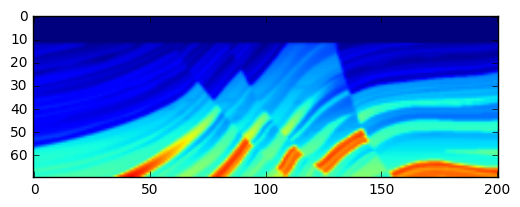

In [5]:
# True velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(vp), vmin= 1.5, vmax=4, aspect=1)
plt.show()

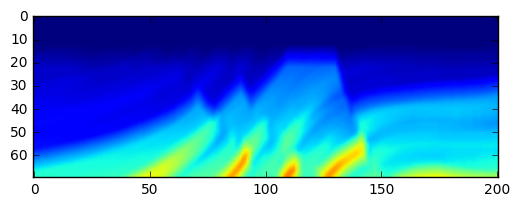

In [6]:
# Smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp), vmin= 1.5, vmax=4, aspect=1)
plt.show()

# Acquisition geometry

In [7]:
# Source function
# Set up the source as Ricker wavelet for f0
def source(t, f0):
    r = (np.pi * f0 * (t - 1./f0))

    return (1-2.*r**2)*np.exp(-r**2)
# Define seismic data.
data = IShot()

f0 = .010
dt = model.get_critical_dt()
t0 = 0.0
tn = 2000
nt = int(1+(tn-t0)/dt)

time_series = source(np.linspace(t0, tn, nt), f0)
location = (origin[0] + dimensions[0] * spacing[0] * 0.5,
            origin[1] + 2 * spacing[1])
data.set_source(time_series, dt, location)

receiver_coords = np.zeros((101, 2))
receiver_coords[:, 0] = np.linspace(2 * spacing[0],
                                    origin[0] + (dimensions[0] - 2) * spacing[0],
                                    num=101)
receiver_coords[:, 1] = origin[1] + 2 * spacing[1]
data.set_receiver_pos(receiver_coords)
data.set_shape(nt, 101)

# Shot record

In [8]:
Acoustic = Acoustic_cg(model, data, t_order=2, s_order=6)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e2efe6bcd6f86adb638779f4da0070fbcdfc6c35.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a43b9d25078da30b2095cb46953bea031a2028b2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b1a78748b9ee2f38def62f33ea97a1ed5cba639.cpp


In [9]:
print("Applying Forward")
rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3d1563e35bc29795d1975e07b1140adcc967f37a.cpp


Applying Forward


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/2f4f4f6961ecd1f8686473e6274ade572403ae5f.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/74ac3976f70ec697a825d2e88d14af1a18532d87.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/689788784d40680a29a7393f329f5cd1580b1bed.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/593dd86b47cef7147ede94580ee25152ed48f263.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 1.194948 s (39 MCells/s)


Stencil: 2.437500 OI, 1.64 GFlops/s (time: 1.192741 s)


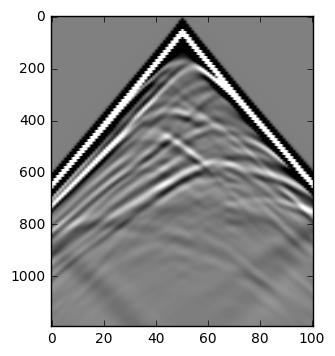

In [10]:
# Shot record
fig2 = plt.figure()
l = plt.imshow(rec, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

# RTM

In [11]:
nsrc = 101
sources = np.linspace(2 * spacing[0],origin[0] + (dimensions[0] - 2) * spacing[0],num=101)
grad = np.zeros(dimensions)
grad = np.pad(grad, [(40, 40),(40,40)],'edge')

for i in range(0,nsrc):
    location = (sources[i],origin[1] + 2 * spacing[1])
    data.set_source(time_series, dt, location)
    # True data
    Acoustic = Acoustic_cg(model, data, t_order=2, s_order=6)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)
    # Smooth data and wavefield
    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=6)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)
    # gradient
    grad = grad + Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

In [ ]:
# Smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(grad), aspect=1, cmap=cm.gray)
plt.show()